# Preprocessing of Airbnb dataset

This notebook preprocesses aribnb dataset and gets it ready for use in ML models

In [32]:
# !pip install pyspark==3.0.1 py4j==0.10.9 seaborn
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import warnings
warnings.simplefilter(action='ignore')
# change to your local path to project below
project_path = '/home/jorge/Insync/jorgitoje@gmail.com/OneDrive/Documentos/JORGE/EDUCATION/MASTER_DATASCIENCE/Semester1/AdvancedStatistics/GroupProject/KDS_Statistics_GroupProject'

In [33]:
dataset_path = os.path.join(project_path, 'datasets/Airbnb_price/data_Airbnb.csv')
df_pd = pd.read_csv(dataset_path)
df_pd.set_index('id', inplace=True)


In [34]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('Airbnb_with_PySpark')\
        .getOrCreate()

In [35]:
sc = spark.sparkContext

In [36]:
df_pd['amenities'] = df_pd['amenities'].map(lambda x: x.replace('"', '').replace('{', '').replace('}', '').split(','))
df_pd['first_review'] = pd.to_datetime(df_pd['first_review'])
df_pd['last_review'] = pd.to_datetime(df_pd['last_review'])
df_pd['host_since'] = pd.to_datetime(df_pd['host_since'])
df_pd['host_has_profile_pic'] = df_pd['host_has_profile_pic'].map({'t': True, 'f': False, np.nan: False})
df_pd['host_identity_verified'] = df_pd['host_identity_verified'].map({'t': True, 'f': False, np.nan: False})
df_pd['instant_bookable'] = df_pd['instant_bookable'].map({'t': True, 'f': False})
df_pd['bathrooms'] = df_pd['bathrooms'].fillna(0)
df_pd['bedrooms'] = df_pd['bedrooms'].fillna(0)
df_pd['beds'] = df_pd['beds'].fillna(1)
df_pd['review_scores_rating'] = df_pd['review_scores_rating'].fillna(df_pd['review_scores_rating'].median())
df_pd['host_response_rate'] = df_pd['host_response_rate'].fillna('0').map(lambda x: x.replace('%', '')).astype('int')

In [37]:

df_pd['first_review_days'] = (df_pd['first_review'].fillna(df_pd['first_review'].mean()) - pd.to_datetime('2008-01-01')).dt.days.astype(int)
df_pd['last_review_days'] = (df_pd['last_review'].fillna(df_pd['last_review'].mean()) - pd.to_datetime('2008-01-01')).dt.days.astype(int)
df_pd['host_since_days'] = (df_pd['host_since'].fillna(df_pd['host_since'].mean()) - pd.to_datetime('2008-01-01')).dt.days.astype(int)


In [38]:
amenities = {x for xs in df_pd['amenities'].tolist() for x in xs}
amenities.remove('')
amenities.remove('translation missing: en.hosting_amenity_49')
amenities.remove('translation missing: en.hosting_amenity_50')
amenities = list(amenities)

In [39]:
amenities_df = pd.DataFrame(df_pd['amenities'].apply(lambda x: [amenity in x for amenity in amenities]).tolist(), columns=amenities, index=df_pd.index)
amenities_df

,Washer,Cable TV,Doorman,Hair dryer,Stove,Luggage dropoff allowed,Free parking on premises,Dishes and silverware,Air purifier,Smartlock,...,Host greets you,Safety card,Flat smooth pathway to front door,Microwave,Hot water kettle,BBQ grill,Long term stays allowed,Private living room,Waterfront,Toilet paper
id,,,,,,,,,,,,,,,,,,,,,
6901257,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6304928,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7919400,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13418779,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3808709,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14549287,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13281809,True,True,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18688039,True,False,False,True,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


In [40]:
amenities_df = pd.concat([df_pd['log_price'], amenities_df], axis=1)
significant_amenities = amenities_df[amenities_df.columns[abs(amenities_df.corr()['log_price']) > 0.1]]
significant_amenities.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,log_price,Washer,Cable TV,Doorman,Hair dryer,Indoor fireplace,Iron,Gym,24-hour check-in,Suitable for events,Kitchen,Elevator,Heating,Lock on bedroom door,TV,Family/kid friendly,Private entrance,Dryer
log_price,1.00,0.17,0.24,0.12,0.12,0.17,0.11,0.11,0.11,0.12,0.10,0.10,0.10,-0.13,0.26,0.29,0.11,0.17
Washer,0.17,1.00,0.14,0.13,0.11,0.20,0.13,0.21,0.11,0.07,0.18,0.11,0.12,0.00,0.18,0.15,0.02,0.96
Cable TV,0.24,0.14,1.00,0.14,0.11,0.12,0.14,0.08,0.20,0.03,0.08,0.03,0.14,-0.09,0.37,0.13,0.07,0.15
Doorman,0.12,0.13,0.14,1.00,0.03,-0.03,0.02,0.37,0.09,0.00,0.04,0.36,0.05,-0.04,0.06,0.04,-0.04,0.13
Hair dryer,0.12,0.11,0.11,0.03,1.00,0.08,0.62,0.05,0.32,0.02,0.07,-0.01,0.19,0.14,0.16,0.16,0.16,0.11
Indoor fireplace,0.17,0.20,0.12,-0.03,0.08,1.00,0.09,0.04,0.07,0.10,0.07,-0.10,0.07,0.00,0.11,0.11,0.03,0.20
Iron,0.11,0.13,0.14,0.02,0.62,0.09,1.00,0.05,0.32,0.03,0.10,-0.01,0.20,0.14,0.19,0.16,0.16,0.13
Gym,0.11,0.21,0.08,0.37,0.05,0.04,0.05,1.00,0.06,0.04,0.06,0.21,0.06,0.00,0.10,0.08,-0.04,0.22
24-hour check-in,0.11,0.11,0.20,0.09,0.32,0.07,0.32,0.06,1.00,0.03,0.06,-0.04,0.12,-0.03,0.13,0.17,0.06,0.11
Suitable for events,0.12,0.07,0.03,0.00,0.02,0.10,0.03,0.04,0.03,1.00,0.02,-0.02,0.01,0.03,0.04,0.14,0.04,0.07


In [41]:
significant_amenities.drop(columns=['Lock on bedroom door', 'log_price'], inplace=True)

In [42]:
df_pd['id'] = df_pd.index
significant_amenities['id'] = significant_amenities.index

In [43]:
from pyspark.sql.types import *

data_schema = [
               StructField('id', IntegerType(), True),
               StructField('log_price', DoubleType(), True),
               StructField('property_type', StringType(), True),
               StructField('room_type', StringType(), True),
               StructField('accommodates', IntegerType(), True),
               StructField('bathrooms', DoubleType(), True),
               StructField('bed_type', StringType(), True),
               StructField('cancellation_policy', StringType(), True),
               StructField('cleaning_fee', BooleanType(), True),
               StructField('city', StringType(), True),
               StructField('host_response_rate', IntegerType(), True),
               StructField('instant_bookable', BooleanType(), True),
               StructField('neighbourhood', StringType(), True),
               StructField('number_of_reviews', IntegerType(), True),
               StructField('review_scores_rating', DoubleType(), True),
               StructField('bedrooms', DoubleType(), True),
               StructField('beds', DoubleType(), True),
               StructField('first_review_days', IntegerType(), True),
               StructField('host_since_days', IntegerType(), True),
            ]
data_schema = StructType(fields=data_schema)

In [44]:
df = spark.createDataFrame(df_pd[['id', 'log_price', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 
                                 'city', 'host_response_rate', 'instant_bookable', 'neighbourhood', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds',
                                 'first_review_days', 'host_since_days']], schema=data_schema)

In [45]:
df = df.join(spark.createDataFrame(significant_amenities), 'id')

In [46]:
from pyspark.sql.functions import concat, col, lit, isnan

df = df.select("*", concat(col("city"),lit("-"),col("neighbourhood")).alias("city-neigh"))

22/12/14 23:08:09 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


<AxesSubplot: ylabel='count'>

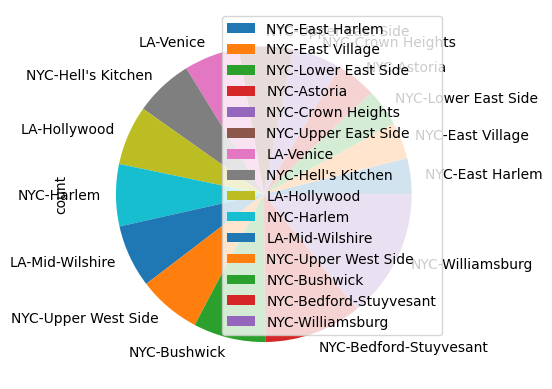

In [47]:
df.filter(~isnan(col('neighbourhood'))).groupBy('city-neigh').count().sort('count').toPandas().set_index('city-neigh')[-15:].plot(kind='pie', y='count')

In [48]:
df = df.drop('neighbourhood')

In [49]:
top_neigh = [x['city-neigh'] for x in df.groupBy('city-neigh').count().sort(col('count').desc()).head(200)]
from pyspark.sql.functions import when


df = df.withColumn("city-neigh", when(df['city-neigh'].isin(top_neigh) & ~df['city-neigh'].like('%NaN'), df['city-neigh']).otherwise(df['city']))
# df = df.withColumn("city-neigh", when(df['city'] == 'NYC', df['city-neigh']).otherwise(df['city']))

In [50]:
df = df.withColumn("property_type", when(df.property_type.isin(['Apartment', 'House', 'Condominium', 'Townhouse', 'Loft', 'Guesthouse', 'Bed & Breakfast', 'Bungalow', 'Villa', 'Dorm']), df.property_type).otherwise('Other'))

In [51]:
df = df.drop('instant_bookable', 'bed_type', 'bedrooms', 'bathrooms', 'beds')

In [55]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import MaxAbsScaler

In [56]:
cat_cols = ['property_type', 'room_type', 'cancellation_policy', 'city-neigh']
indexers = [StringIndexer(inputCol= c, outputCol= c + "_ind") for c in cat_cols]
encoders = [OneHotEncoder(inputCol= c+"_ind", outputCol= c+ "_one_hot") for c in cat_cols]
pipeline = Pipeline(stages=indexers + encoders)
df_encoded = pipeline.fit(df).transform(df)

In [57]:
df_vectorized = df_encoded.drop(*cat_cols, *[c + '_ind' for c in cat_cols], 'city')

In [58]:
assembler = VectorAssembler(
    inputCols=[col for col in df_vectorized.columns if col not in ['id', 'log_price']],
    outputCol="features")
df_vectorized = assembler.transform(df_vectorized).select(['id', 'features', 'log_price'])
df_vectorized.head()

Row(id=70095, features=SparseVector(241, {0: 2.0, 2: 100.0, 4: 96.0, 5: 2935.0, 6: 3539.0, 7: 1.0, 10: 1.0, 12: 1.0, 13: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 22: 1.0, 23: 1.0, 34: 1.0, 36: 1.0, 74: 1.0}), log_price=4.74493212836325)

In [59]:
scaler = MaxAbsScaler(inputCol='features', outputCol='features_scaled')
df_vectorized = scaler.fit(df_vectorized).transform(df_vectorized)

In [60]:
from pyspark.ml.feature import ChiSqSelector

selector = ChiSqSelector(numTopFeatures=150, featuresCol="features_scaled",
                         outputCol="features_selected", labelCol="log_price")

df_vectorized = selector.fit(df_vectorized).transform(df_vectorized)

In [62]:
df_vectorized_pandas = df_vectorized.toPandas()

In [63]:
df_vectorized_pandas.head()

,id,features,log_price,features_scaled,features_selected
0,70095,"(2.0, 0.0, 100.0, 0.0, 96.0, 2935.0, 3539.0, 1...",4.744932,"(0.125, 0.0, 1.0, 0.0, 0.96, 0.823281907433380...","(0.125, 0.0, 1.0, 0.96, 0.9929854096520764, 1...."
1,114969,"(1.0, 1.0, 0.0, 0.0, 96.0, 2935.0, 2151.0, 0.0...",4.605170,"(0.0625, 1.0, 0.0, 0.0, 0.96, 0.82328190743338...","(0.0625, 1.0, 0.0, 0.96, 0.6035353535353536, 0..."
2,253815,"(1.0, 0.0, 0.0, 0.0, 96.0, 2935.0, 2394.0, 0.0...",3.912023,"(0.0625, 0.0, 0.0, 0.0, 0.96, 0.82328190743338...","(0.0625, 0.0, 0.0, 0.96, 0.6717171717171718, 0..."
3,288038,"(2.0, 0.0, 100.0, 0.0, 96.0, 2935.0, 2021.0, 0...",4.595120,"(0.125, 0.0, 1.0, 0.0, 0.96, 0.823281907433380...","(0.125, 0.0, 1.0, 0.96, 0.5670594837261504, 0...."
4,385824,"(4.0, 1.0, 100.0, 2.0, 100.0, 2827.0, 2254.0, ...",6.551080,"(0.25, 1.0, 1.0, 0.003305785123966942, 1.0, 0....","(0.25, 1.0, 1.0, 1.0, 0.6324354657687992, 0.0,..."


In [65]:
jorge = df_encoded.drop(*cat_cols, *[c + '_ind' for c in cat_cols], 'city')

In [67]:
jorge2  =jorge.toPandas()

In [82]:
jorge2.head()
jorge2.columns

Index(['id', 'log_price', 'accommodates', 'cleaning_fee', 'host_response_rate',
       'number_of_reviews', 'review_scores_rating', 'first_review_days',
       'host_since_days', 'Washer', 'Cable TV', 'Doorman', 'Hair dryer',
       'Indoor fireplace', 'Iron', 'Gym', '24-hour check-in',
       'Suitable for events', 'Kitchen', 'Elevator', 'Heating', 'TV',
       'Family/kid friendly', 'Private entrance', 'Dryer',
       'property_type_one_hot', 'room_type_one_hot',
       'cancellation_policy_one_hot', 'city-neigh_one_hot'],
      dtype='object')

# Apply models here

In [71]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from matplotlib import pyplot
import os
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [80]:
data = jorge2.filter(items=[
    'log_price', 'accommodates', 'host_response_rate',
       'number_of_reviews', 'review_scores_rating', 'first_review_days',
       'host_since_days', 'Washer'
])
y = data['log_price']
X = data.drop('log_price', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)

In [81]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

# optimize the α hyperparameter of Lasso regression
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

search.fit(X_train,y_train)


Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-0.359 total time=   0.1s
[CV 2/5] END .................model__alpha=0.1;, score=-0.360 total time=   0.1s
[CV 3/5] END .................model__alpha=0.1;, score=-0.352 total time=   0.1s
[CV 4/5] END .................model__alpha=0.1;, score=-0.358 total time=   0.1s
[CV 5/5] END .................model__alpha=0.1;, score=-0.358 total time=   0.1s
[CV 1/5] END .................model__alpha=0.2;, score=-0.392 total time=   0.1s
[CV 2/5] END .................model__alpha=0.2;, score=-0.388 total time=   0.1s
[CV 3/5] END .................model__alpha=0.2;, score=-0.384 total time=   0.1s
[CV 4/5] END .................model__alpha=0.2;, score=-0.388 total time=   0.1s
[CV 5/5] END .................model__alpha=0.2;, score=-0.386 total time=   0.1s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-0.444 total time=   0.1s
[CV 2/5] END .model__alpha=0.30000000000000004;

KeyboardInterrupt: 

In [84]:
import sklearn
sklearn.datasets.load_digits

https://scikit-learn.org/stable/datasets/toy_dataset.html



AttributeError: module 'sklearn' has no attribute 'datasets'